# Generative Adversarial Networks 
## First attempt at generating doodles

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
from PIL import Image

This notebook goal is as the same time **experiencing Generative Adversarial Networks** and improving my **PyTorch** profiency

## Dataset 
![](https://abovethelaw.com/wp-content/uploads/2013/10/Raccoon-USE.jpg)
The idea was to used a simple toy dataset. I tried with a subset from the [Quickdraw](https://quickdraw.withgoogle.com/) dataset from Google. <br>
I took a subset with only racoons on https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/ <br>
Info available on Github https://github.com/googlecreativelab/quickdraw-dataset <br>


### Reading the images

In [3]:
raccoon_data = np.load("C:/data/gans/raccoon.npy",encoding="latin1").reshape(-1,28,28)

In [4]:
len(raccoon_data)

119588

### Visualize the images

In [5]:
def plot_sample(images,n_row=8, n_col=18):
    """
    Helper function to plot a gallery of images
    """
    
    # Random selection
    selection = np.random.randint(0,len(images),n_row*n_col)
    selection = images[selection]
    
    # Plot figure
    plt.figure(figsize=(1 * n_col, 1 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(selection[i],interpolation="nearest",cmap='Greys')
        plt.xticks(())
        plt.yticks(())

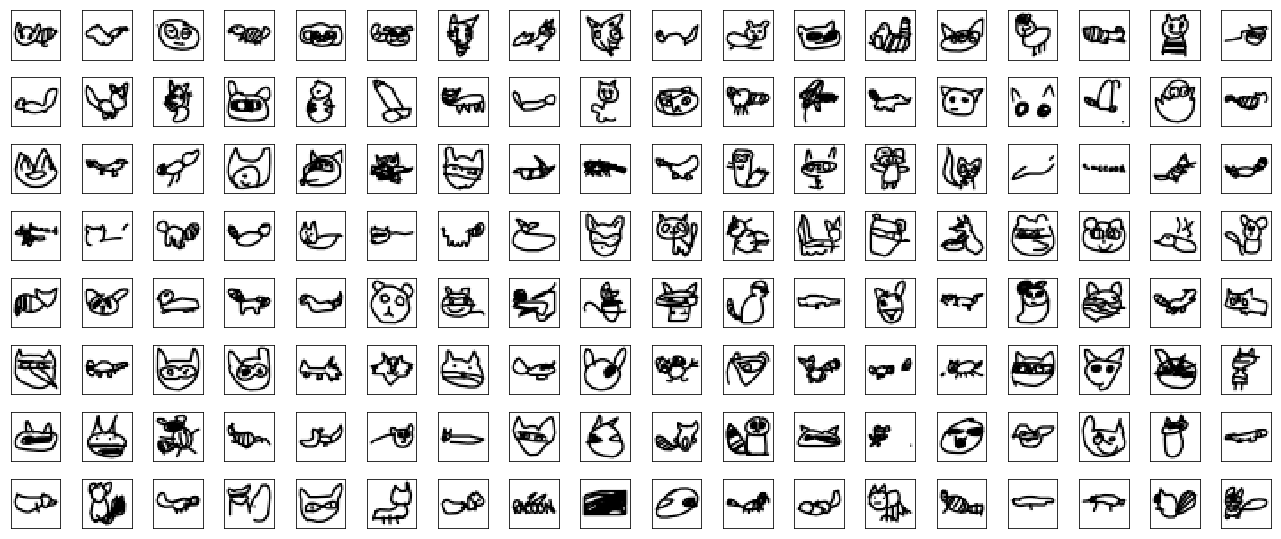

In [6]:
plot_sample(raccoon_data)

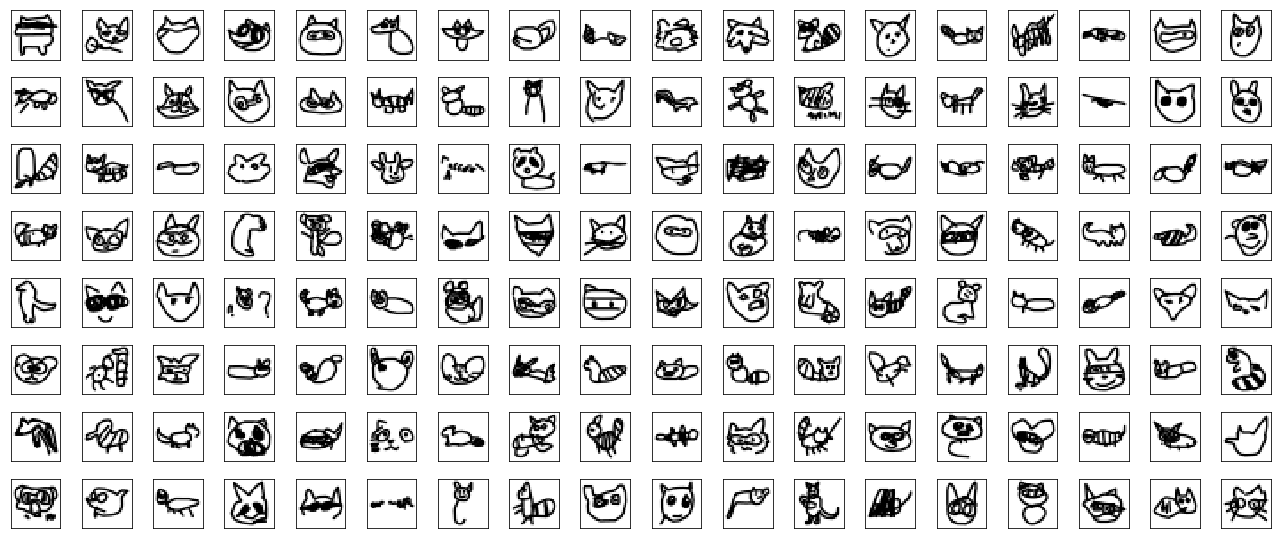

In [10]:
plot_sample(raccoon_data)

# Creating a GAN model

##### References

- [Generative Adversarial Networks (GANs) in 50 lines of code](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f) and the [github repo](https://github.com/devnag/pytorch-generative-adversarial-networks)
- [Vanilla Gan](https://nbviewer.jupyter.org/github/greydanus/mnist-gan/blob/master/vanilla-gan.ipynb)

## Imports and parameters

In [69]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils

In [70]:
batch_size = 64
G_lr = D_lr = 1e-3
global_step = 0
print_every = 1000
total_steps = 10000
cost_func = nn.BCELoss()

D_ent = 100
D_side = 28
D_img = D_side**2
D_hidden = 128

In [129]:
class RacoonDataset(torch.utils.data.Dataset):
    def __init__(self,data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,key):
        return self.data[key]
    
raccoon_dataset = RacoonDataset(raccoon_data.reshape(-1,D_img))

In [130]:
loader = torch.utils.data.DataLoader(raccoon_dataset, batch_size=batch_size, shuffle=True)

In [131]:
def imshow(inp, c, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    
    plt.title(title) if title is not None else plt.title(str(c).zfill(3))
    if save:
        if not os.path.exists('vanilla-out/'):
            os.makedirs('vanilla-out/')
        plt.savefig('vanilla-out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        plt.close(fig)

In [132]:
def entropy():
    return Variable(torch.randn(batch_size, D_ent))

def raccoon():
    data = next(iter(loader))
    return Variable(data) #.resize(batch_size, D_img)

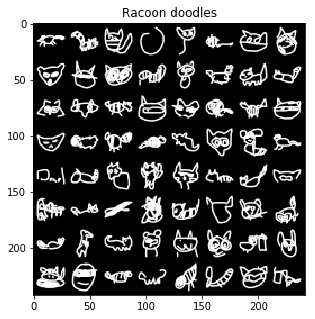

In [133]:
inputs = raccoon().data.resize_(batch_size,1,D_side,D_side)
out = utils.make_grid(inputs)
imshow(out, c=0, save=False, title="Racoon doodles")

## Generator and discriminator models

In [122]:
class SimpleNN(torch.nn.Module):
    def __init__(self, batch_size, input_dim, h_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.W1 = nn.Parameter(torch.randn(input_dim, h_dim)*0.075)
        self.b1 = nn.Parameter(torch.randn(h_dim)*0.075)
        self.W2 = nn.Parameter(torch.randn(h_dim, output_dim)*0.075)
        self.b2 = nn.Parameter(torch.randn(output_dim)*0.075)

    def forward(self, X):
        h = F.relu(X.mm(self.W1) + self.b1.repeat(X.size(0), 1))
        return F.sigmoid(h.mm(self.W2) + self.b2.repeat(X.size(0), 1))
    
D = SimpleNN(batch_size, D_img, D_hidden, 1)
G = SimpleNN(batch_size, D_ent, D_hidden, D_img)

# Run the GAN model

## Define the different components

In [123]:
optimizers = {'D': torch.optim.Adam(D.parameters(), lr=D_lr),
              'G': torch.optim.Adam(G.parameters(), lr=G_lr)}
ones_label = Variable(torch.ones(batch_size))
zeros_label = Variable(torch.zeros(batch_size))

## Main Loop

In [ ]:
# generic train loop
for global_step in range(global_step, total_steps+global_step+1):
    
    # ======== DISCRIMINATOR STEP ======== #
    # forward
    z = entropy() ; X = raccoon()
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    # backward
    D_loss_real = cost_func(D_real, ones_label)
    D_loss_fake = cost_func(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    optimizers['D'].step()
    [o.zero_grad() for o in optimizers.values()]
    
    # ======== GENERATOR STEP ======== #
    # forward
    z = entropy()
    G_sample = G(z)
    D_fake = D(G_sample)
    
    # backward
    G_loss = cost_func(D_fake, ones_label)
    G_loss.backward()
    optimizers['G'].step()
    [o.zero_grad() for o in optimizers.values()]

    # ======== DISPLAY PROGRESS ======== #
    if global_step % print_every == 0:
        print('step {}: D loss: {:.4f}; G loss: {:.4f}'
              .format(global_step, D_loss.data.numpy()[0], G_loss.data.numpy()[0]))
        
        samples = G(entropy()).data.resize_(batch_size,1,D_side,D_side)
        samples = utils.make_grid(samples)
        imshow(samples, c = global_step // print_every, save=True)

# GANs using Keras

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [9]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [11]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

In [19]:
class Raccoon_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = raccoon_data.reshape(-1,784)
        self.x_train = self.x_train.reshape(-1, self.img_rows,self.img_cols, 1).astype(np.float32)

        
        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

In [ ]:
dcgan = Raccoon_DCGAN()
timer = ElapsedTimer()
dcgan.train(train_steps=10000, batch_size=256, save_interval=500)
timer.elapsed_time()
dcgan.plot_images(fake=True)
dcgan.plot_images(fake=False, save2file=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________